# Exploring Reinforcement Learning using Q Learning

The code tackles a Travelling Salesman problem TSP, creates a trained Q learning matrix and visualises various tests. 

Author: Craig Sim

### References

This solution was inspired by the article "Implementation of a Reinforcement Learning Algorithm from Scratch"
by Kevin Speyer

https://www.cybertec-postgresql.com/en/implementation-of-a-reinforcement-learning-algorithm-from-scratch/


### Create the Distance Matrix

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.ticker import MaxNLocator
import seaborn as sns

#Global Variables
BEST_RESULT=66

A = [[0, 17, 19, 16, 11],
      [17, 0, 13, 14, 19],
      [19, 13, 0, 12, 15],
      [16, 14, 12, 0, 13],
      [11, 19, 15, 13, 0]]
n_dest = 5
Rmatrix = np.zeros([n_dest,n_dest])

length = len(A)
for i in range(length):
    L = A[i]
    length_L = len(L)
    for j in range(length_L):
        Rmatrix[i,j] = L[j]

print(Rmatrix)

[[ 0. 17. 19. 16. 11.]
 [17.  0. 13. 14. 19.]
 [19. 13.  0. 12. 15.]
 [16. 14. 12.  0. 13.]
 [11. 19. 15. 13.  0.]]


### The Reward function which is = 1/distance

In [35]:
def update_Qmatrix(Q, R, state, action, alpha=0.7, gamma=0.8):
   reward =  1.0/ R[state,action]  # Set immediate reward as inverse of distance
   next_reward = Q[action,:].max()
   Q[state,action] += alpha * (reward + gamma * next_reward - Q[state,action])
   return Q

### The Epsilon Greedy function

In [36]:
def epsilon_greedy(Q, epsilon, available_actions, state):
    #decide next action:
    if random.random() < epsilon:  # explore random actions
        action = random.choice(available_actions) 
    else:  # exploit known data from Q matrix
        best_action_index = Q[state, available_actions].argmax() 
        action = available_actions[best_action_index]
    return action

### The state transition function
TSP cannot visit a city its already visited, this function ensures this does not happen)

In [37]:
def choice_of_new_destinations(places_visited):
    return [ destination for destination in range(n_dest) if destination not in places_visited ]
    

### A function that runs the trained Q matrix

In [38]:
def calculate_tour_distance(Q, R, print_result=False):
    trajectory = [0] 
    state = 0
    distance = 0.
    available_actions = choice_of_new_destinations(trajectory) 
    while available_actions: # until all destinations are visited once (only)
       action_index = Q[state, available_actions].argmax()
       action = available_actions[action_index]
       distance += R[state, action]
       trajectory.append(action)
       state = trajectory[-1] 
       available_actions = choice_of_new_destinations(trajectory) 
    # Back to warehouse
    action = 0
    distance += R[state, action]
    error = distance/BEST_RESULT
    
    if print_result is True:
        #Print Results: 
        print('Best trajectory found:') 
        print(' -> '.join([str(b) for b in trajectory])) 
        print(f'Distance Travelled: {distance}')
        print(f'Error: {error}')
        
    return distance, error

### A function to visualise a chart that displays the cost function versus epochs

In [39]:
def plot_grid(res, l):
    results = []
    for x in range(5):
        results.append(pd.DataFrame(res[x], columns = ['Epochs', 'Difference vs Optimal Route', 'Tour Distance']))

    losslist = []
    for i in range(5):
        mean = round((results[i]['Tour Distance'].mean()/BEST_RESULT), 5)
        loss = "Mean loss = " + str(mean) + " for " + l[i]
        losslist.append(loss)

    ###########################################################################
    #Create a timeseries barplot and lineplot to analyse the close frequency
    ###########################################################################
    sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 0.6})
    plt.figure(figsize=(16, 6))
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    title = "Q Learning for Travelling Salesman Problem"
    plt.title(title, fontsize= 15)
    
    ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results[0])
    ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results[1], color='black')
    ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results[2], color='green')
    ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results[3], color='yellow')
    ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results[4], color='red')
    ax.legend(losslist)

    plt.show(sns)
    

    

### The Training Function

Train the model (create the Q Matrix)

In [40]:
import random

def train(R, t_iter=120, t_epsilon=True, alpha=0.7, gamma=0.8, decay=0.001, print_route=False ):
    Q = np.zeros([n_dest,n_dest]) 
    epsilon = 1. # Exploration parameter 
    n_train = int(t_iter) # Number of training iterations
    results_list = []
    for i in range(n_train): 
        trajectory = [0] # initial state is at A (from STD) 
        state = 0
        available_actions = choice_of_new_destinations(trajectory)  
        while available_actions: # until all destinations are visited 
           action = epsilon_greedy(Q, epsilon, available_actions, state)
           # update Q: core of the training phase
           Q = update_Qmatrix(Q, R, state, action) 
           trajectory.append(action) 
           state = trajectory[-1] 
           available_actions = choice_of_new_destinations(trajectory)  

        # Last trip: from last destination to A 
        action = 0
        Q = update_Qmatrix(Q, R, state, action, alpha, gamma) 
        trajectory.append(0)
        
        epsilon = max(epsilon - decay, 0.001) # decay schedule for epsilon

        #Calculate graph metrics
        tour_dist, error = calculate_tour_distance(Q, R, print_route)
        #Create the result
        result = []
        result.append(i)     
        result.append(error)
        result.append(tour_dist)
        results_list.append(result)
    #print(Q)
    return results_list

### Train the TSP Q learning matrix on default parameters

In [41]:
results_list = train(Rmatrix, t_iter=100, print_route=True)

Best trajectory found:
0 -> 1 -> 3 -> 4 -> 2
Distance Travelled: 78.0
Error: 1.1818181818181819
Best trajectory found:
0 -> 2 -> 1 -> 4 -> 3
Distance Travelled: 80.0
Error: 1.2121212121212122
Best trajectory found:
0 -> 4 -> 3 -> 1 -> 2
Distance Travelled: 70.0
Error: 1.0606060606060606
Best trajectory found:
0 -> 4 -> 3 -> 1 -> 2
Distance Travelled: 70.0
Error: 1.0606060606060606
Best trajectory found:
0 -> 2 -> 4 -> 3 -> 1
Distance Travelled: 78.0
Error: 1.1818181818181819
Best trajectory found:
0 -> 1 -> 2 -> 4 -> 3
Distance Travelled: 74.0
Error: 1.121212121212121
Best trajectory found:
0 -> 4 -> 3 -> 2 -> 1
Distance Travelled: 66.0
Error: 1.0
Best trajectory found:
0 -> 4 -> 1 -> 2 -> 3
Distance Travelled: 71.0
Error: 1.0757575757575757
Best trajectory found:
0 -> 4 -> 1 -> 2 -> 3
Distance Travelled: 71.0
Error: 1.0757575757575757
Best trajectory found:
0 -> 3 -> 2 -> 1 -> 4
Distance Travelled: 71.0
Error: 1.0757575757575757
Best trajectory found:
0 -> 3 -> 1 -> 4 -> 2
Distance Tr

### Visualise the trained Q learning results

No handles with labels found to put in legend.


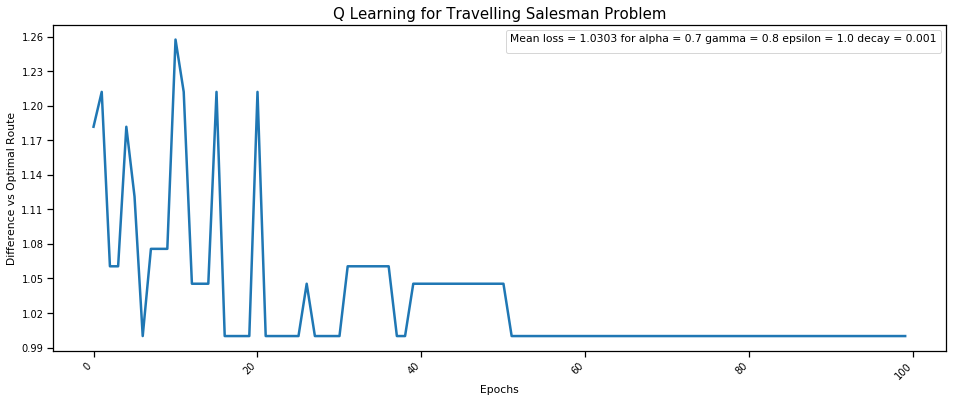

Tour Distance
count    100.000000
mean      68.000000
std        3.722712
min       66.000000
25%       66.000000
50%       66.000000
75%       69.000000
max       83.000000


In [42]:
import pandas as pd

results = pd.DataFrame(results_list, columns = ['Epochs', 'Difference vs Optimal Route', 'Tour Distance'])
mean = round((results['Tour Distance'].mean()/BEST_RESULT), 5)
legend = "Mean loss = " + str(mean) + " for alpha = 0.7 gamma = 0.8 epsilon = 1.0 decay = 0.001"

sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45, horizontalalignment='right')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
title = "Q Learning for Travelling Salesman Problem"
plt.title(title, fontsize= 15)

ax = sns.lineplot(x='Epochs', y='Difference vs Optimal Route', data=results)
ax.legend(title=legend, loc='upper right')

plt.show(sns)

stats = results["Tour Distance"].describe().to_string()
print("Tour Distance\n" + stats)



## Vary the Hyperparameters to compare learning 

Vary alpha, gamma and decay factor

### Vary alpha

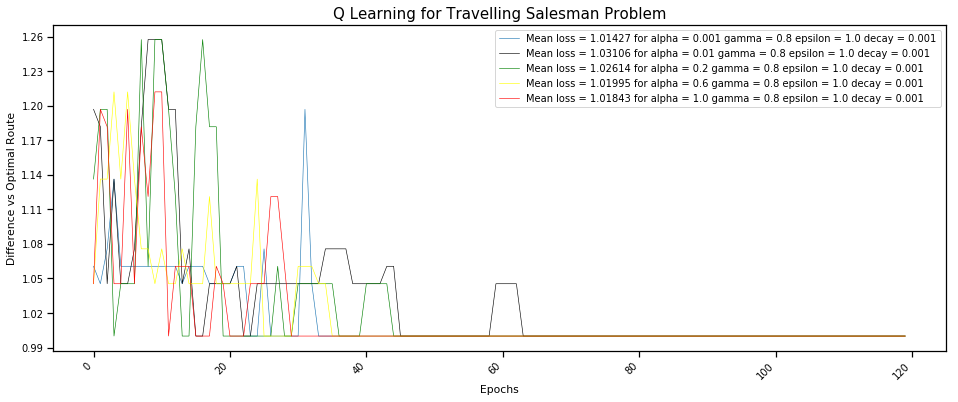

In [43]:
Alpha  = [0.001, 0.01, 0.2, 0.6, 1.0] #Learning Rate
length = len(Alpha)
res = []
l = []

for i in range(length):
    list_alpha = Alpha[i]
    #result = training_epochs(Rmatrix, e_epochs=1, e_alpha=list_alpha)
    result = train(Rmatrix, t_iter=120, alpha=list_alpha)
    res.append(result)
    label = "alpha = " + str(list_alpha) + " gamma = 0.8 epsilon = 1.0 decay = 0.001"
    l.append(label)
    
plot_grid(res, l)

### Vary Gamma

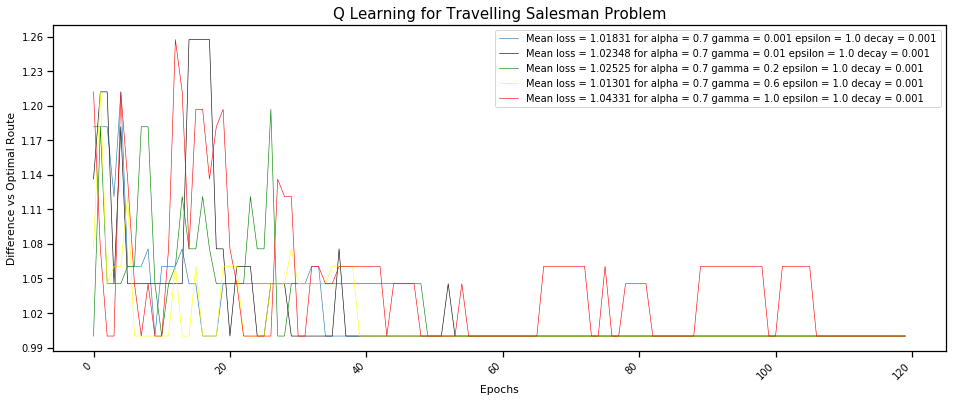

In [44]:
Gamma  = [0.001, 0.01, 0.2, 0.6, 1.0]
length = len(Gamma)
r = []
l = []

for i in range(length):
    list_gamma = Gamma[i]
    result = train(Rmatrix, t_iter=120, gamma=list_gamma)
    r.append(result)
    label = "alpha = 0.7 gamma = " + str(list_gamma) + " epsilon = 1.0 decay = 0.001"
    l.append(label)
    
plot_grid(r, l)

### Vary Epsilon Decay

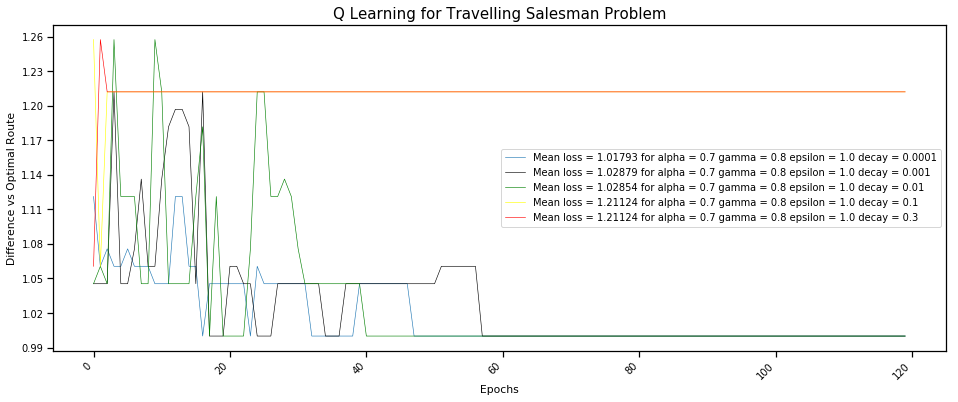

In [45]:
Decay  = [0.0001, 0.001, 0.01, 0.1, 0.3]
length = len(Decay)
r = []
l = []

for i in range(length):
    list_decay = Decay[i]
    result = train(Rmatrix, t_iter=120, t_epsilon=False, decay=list_decay)
    r.append(result)
    label = "alpha = 0.7 gamma = 0.8 epsilon = 1.0 decay = " + str(list_decay)
    l.append(label)
    
plot_grid(r, l)